![](https://www.vaya-antarctica.com/wp-content/uploads/Orion-Header-1920x1020.jpg)

I have already posted one [kernel](https://www.kaggle.com/rackovic1994/feature-engineering) on Airbus Ship Detection Challenge with brunt on Image Processing. In this kernel I will go through **end-to-end U-Net model** for Object Detection trying to find and localize ship on satelite images.

Things I will cover here are
1.         Problem setting of this competition
2.        Image generator for CNN
3.        Metrics and loss function
4.        Building CNN and making predictions

So, let's start with **Problem Setting**. The goal of competition is to detect ship at the satelite image. We have original images (around 100 k of them) and corresponding masks for each occuring ship (in .csv format, so we need to transform it into an image). So, make NN model, feed it with images and masks and get predictions. Piece of cake, right?

Let's go step by step. (And yes, if you don't have GPU it's better not to try on this competition)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import warnings
from keras.models import load_model
warnings.filterwarnings("ignore")

/home/programs/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
os.chdir("/home/atarasov/datasets/airbus_challenge/")
os.listdir(os.getcwd())

['sample_submission.csv', 'test', 'train_ship_segmentations.csv', 'train']

In [4]:
marks = pd.read_csv('train_ship_segmentations.csv') # Markers for ships
images = os.listdir('train') # Images for training
test_images = os.listdir('test') # Images for testing
os.chdir("train")

In [5]:
def mask_part(pic):
    '''
    Function that encodes mask for single ship from .csv entry into numpy matrix
    '''
    back = np.zeros(768**2)
    starts = pic.split()[0::2]
    lens = pic.split()[1::2]
    for i in range(len(lens)):
        back[(int(starts[i])-1):(int(starts[i])-1+int(lens[i]))] = 1
    return np.reshape(back, (768, 768, 1))

def is_empty(key):
    '''
    Function that checks if there is a ship in image
    '''
    df = marks[marks['ImageId'] == key].iloc[:,1]
    if len(df) == 1 and type(df.iloc[0]) != str and np.isnan(df.iloc[0]):
        return True
    else:
        return False
    
def masks_all(key):
    '''
    Merges together all the ship markers corresponding to a single image
    '''
    df = marks[marks['ImageId'] == key].iloc[:,1]
    masks= np.zeros((768,768,1))
    if is_empty(key):
        return masks
    else:
        for i in range(len(df)):
            masks += mask_part(df.iloc[i])
        return np.transpose(masks, (1,0,2))

Randomly chosen images with corresponding masks


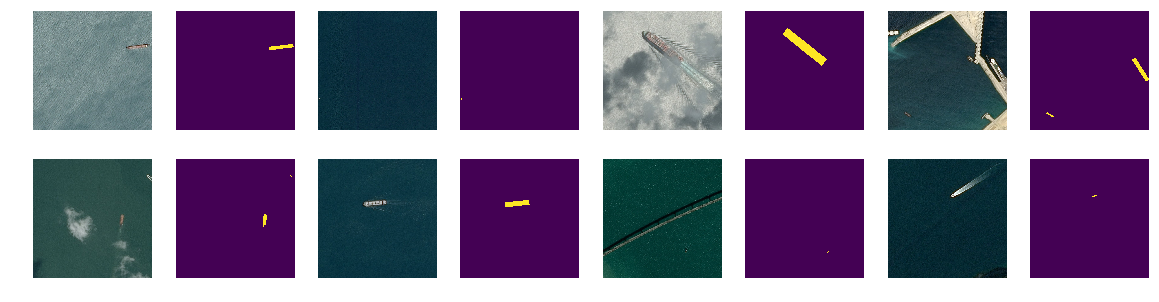

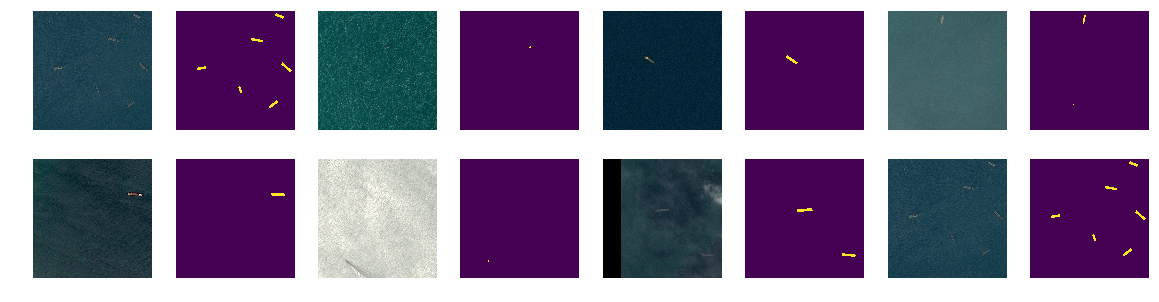

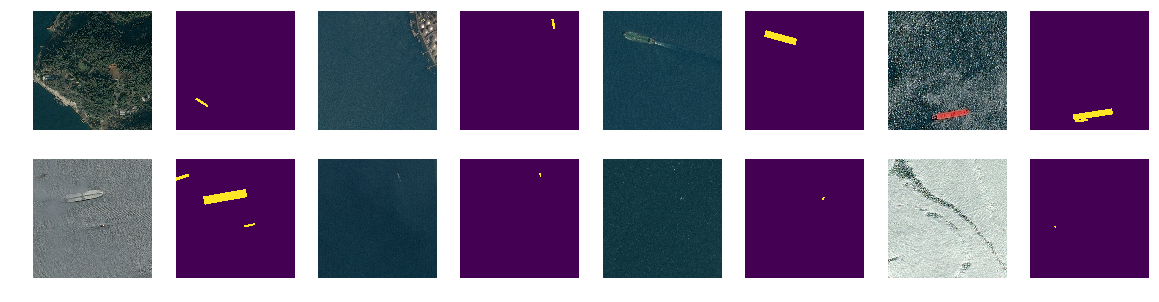

In [6]:
def draw(lista):
    l = int(len(lista)/2)
    plt.figure(figsize = (20,5))
    for i in range(2*l):
        plt.subplot(2,2*l,2*i+1)
        plt.imshow(plt.imread(lista[i]))
        plt.axis('off')
        plt.subplot(2,2*l,2*i+2)
        plt.imshow(masks_all(lista[i])[:,:,0])
        plt.axis('off')
        #plt.suptitle('Images and corresponding masks', fontsize = 22)
    plt.show()
print('Randomly chosen images with corresponding masks')
draw(np.random.choice([i for i in images[:200] if not is_empty(i)], size = 8))
draw(np.random.choice([i for i in images[200:400] if not is_empty(i)], size = 8))
draw(np.random.choice([i for i in images[400:600] if not is_empty(i)], size = 8))

If you look closely on these plots, you'll notise that there are a lot of ships which are really hard to find; so don't be surprised if model struggles detect them. But, on the bright side, there are no overllaping of masks, which is a commong problem in some similar tasks; this is one burden less.

## Image Generator
Popular tactics in computer vision problems for fighting lack of data is **Data Augmentation**. It consists of performing different transformations on existing images in order to get 'new' images that are in it's core the same, but still differ enough that machine considers them different.

In order to feed our Net with continous stream of images, we need image generator. Generators in Python are simply speaking *functions that have varying number of outputs*.  Keras is equiped with built-in *Image Data Generator*, but for this competition I want to make mine own. It's not that hard when you go through it.

In [7]:
def transform(X, Y):
    '''
    Function for augmenting images. 
    It takes original image and corresponding mask and performs the
    same flipping and rotation transforamtions on both in order to 
    perserve the overlapping of ships and their masks
    '''
# add noise:
    x = np.copy(X)
    y = np.copy(Y)
    x[:,:,0] = x[:,:,0] + np.random.normal(loc=0.0, scale=0.01, size=(768,768))
    x[:,:,1] = x[:,:,1] + np.random.normal(loc=0.0, scale=0.01, size=(768,768))
    x[:,:,2] = x[:,:,2] + np.random.normal(loc=0.0, scale=0.01, size=(768,768))
    # Adding Gaussian noise on each rgb channel; this way we will NEVER get two completely same images.
    # Note that this transformation is not performed on Y 
    x[np.where(x<0)] = 0
    x[np.where(x>1)] = 1
# axes swap:
    if np.random.rand()<0.5: # 0.5 chances for this transformation to occur (same for two below)
        x = np.swapaxes(x, 0,1)
        y = np.swapaxes(y, 0,1)
# vertical flip:
    if np.random.rand()<0.5:
        x = np.flip(x, 0)
        y = np.flip(y, 0)
# horizontal flip:
    if np.random.rand()<0.5:
        x = np.flip(x, 1)
        y = np.flip(y, 1)
    return x, y  

In [8]:
def plot_transformed(file):
    '''
    Plots specified Original image and five augmentations
    (five images created transforming original with function 'transform()')
    '''
    X, Y = plt.imread(file), masks_all(file)
    plt.figure(figsize = (19,8))
    plt.subplot(253, title ='Original Image')
    X, Y = plt.imread(file)/255, masks_all(file)
    plt.imshow(X)
    plt.axis('off')
    plt.subplot(256, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')
    plt.subplot(257, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')    
    plt.subplot(258, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')
    plt.subplot(259, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')    
    plt.subplot(2,5,10, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')
    plt.suptitle(file,x=0.3, y=0.7, verticalalignment ='top', fontsize = 22)
    plt.show()

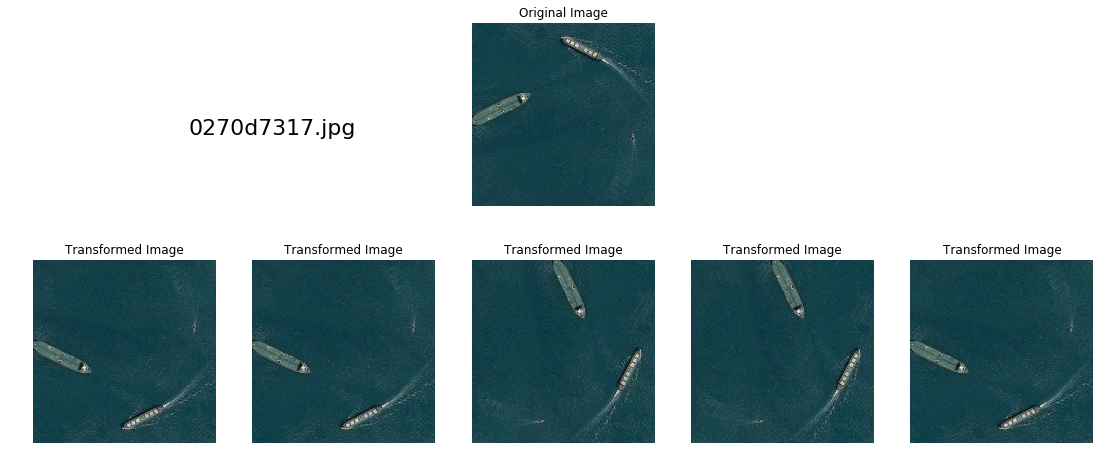

In [9]:
plot_transformed('0270d7317.jpg')

At the figure abowe you can see image *0270d7317.jpg* and five 'new' images created transforming it.

In [10]:
def make_batch(files, batch_size):
    '''
    Creates batches of images and masks in order to feed them to NN
    '''
    X = np.zeros((batch_size, 768, 768, 3))
    Y = np.zeros((batch_size, 768, 768, 1)) # I add 1 here to get 4D batch
    for i in range(batch_size):
        ship = np.random.choice(files)
        X[i] = (io.imread(ship))/255.0 # Original images are in 0-255 range, I want it in 0-1
        Y[i]= masks_all(ship)
    return X, Y

Finally, it is time to create Generator function combining two functions abowe. Images in batch are chosen at random so we can have one image occuring multiple times even in a single batch, but on each image in batch 'transform()' function is invoked fighting this problem.

In [11]:
def Generator(files, batch_size):
    '''
    Generates batches of images and corresponding masks
    '''
    while True:
        X, Y = make_batch(files, batch_size)
        for i in range(batch_size):
            X[i], Y[i] = transform(X[i], Y[i])
        yield X, Y

## Metrics and Loss Function

Keras package has a lot of built-in metrics, but default metrics are not always good choice. In this problem we need to make our own function for measuring quality of model. Metric I'll be using is called **Intersection over Union**. It is nicely presented at the figure below, where *B1* would present ground truth mask of a ship and *B2* is predicted mask. When this mattching is peerfect, metric value is 1 and the lower predicting precison is, the lower is this value (down to zero).
![](https://lovesnowbest.site/2018/02/27/Intro-to-Object-Detection/iou.png)
Below are implementations of *IoU*, which calculates this ratio for masks, and *back_IoU*, that does the same thing only now consiering background insted of masks. For metrics in model you can use both of these or only the first one (I wouldn't advise only the second one) .

But, when training NN, the **loss function** is the one that really matters. Simple way to create loss function is to take negative value of IoU metric. In this way we obtain function that decreases when our prediction is improving and increases otherwise.

In [12]:
# Intersection over Union for Objects
def IoU(y_true, y_pred, tresh=1e-10):
    Intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    Union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - Intersection
    return K.mean( (Intersection + tresh) / (Union + tresh), axis=0)

# Intersection over Union for Background
def back_IoU(y_true, y_pred):
    return IoU(1-y_true, 1-y_pred)

# Loss function
def IoU_loss(in_gt, in_pred):
    #return 2 - back_IoU(in_gt, in_pred) - IoU(in_gt, in_pred)
    return 1 - IoU(in_gt, in_pred)

## U-Net Architecture
U-Net is a Convolutional Neural Network developed primarily for segmentation and object detection on biomedical images. It is suitable for this problem too cause we need model that takes image as input and also outputs an image.

![](https://i.imgur.com/ZXj1nzK.png)
Our architecture is basicaly the same as the one presented at this shema, borrowed from [here](https://imgur.com/gallery/7FHkQ). Network consists of two 'parts', first beeing common convolutional model with convolutions and pooling layers, decreasing image width and height but increasing number of channels. What makes it different is second 'part' consisting of *upsamplig*, where we have practically the inverse model, increasing width and height but decreasing channels number. This is acheived using transposed convolution and concatenation.

### Building model
Model here is fairly simple in order to execute it easily, but you can create more layers and play with parameters, only looking carefully on the input and output dimensions. As you can see from the model summary both have the same dimensions (except for the number of channels). It is easy to preserve dimensions, you only need to use *padding='same'* and concatenate layers that are supposed to have the same dimensions.

In [13]:
inputs = Input((768, 768, 3))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)

u5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c5 = Conv2D(32, (3, 3), activation='relu', padding='same') (u5)
c5 = Conv2D(32, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c2])
c6 = Conv2D(16, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(16, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c1], axis=3)
c7 = Conv2D(8, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(8, (3, 3), activation='relu', padding='same') (c7)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c7)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss= IoU_loss, metrics=[IoU, back_IoU])
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 768, 768, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 768, 768, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 384, 384, 8)  0        

 Setting batch_size = 200 and steps_per_epoch = 500 gives 200*500 = 100.000 images to train on.
 That is around the same size of available training set, so you shouldn't go under this, but
 considering our generator function, probably a lot of images won't be taken in consideration, so
 I encourage you to increase both, batch size and steps, freely.  
 
 Here, I will put absurdly small parameters just in order to check if everithing is working fine.

In [36]:
os.getcwd()

'/home/atarasov/datasets/airbus_challenge/test'

In [14]:
# Checkpoint
filepath="/home/orehusevych/Airbus/keras_initial.hdf5"

In [33]:
model = load_model(filepath=filepath_test, custom_objects={'IoU_loss': IoU_loss, 'IoU': IoU, 'back_IoU': back_IoU})

In [34]:
model_checkpoint = ModelCheckpoint(filepath=filepath_test, monitor='loss', verbose=1, save_best_only=True)

In [38]:
model.fit_generator(Generator(images, batch_size = 16), steps_per_epoch = 300, epochs = 50, 
                    callbacks=[model_checkpoint])

Epoch 1/50
300/300 [==============================] - 909s 3s/step - loss: 0.2808 - IoU: 0.7192 - back_IoU: 0.9985
Epoch 2/50
300/300 [==============================] - 915s 3s/step - loss: 0.2860 - IoU: 0.7140 - back_IoU: 0.9986
Epoch 3/50
300/300 [==============================] - 914s 3s/step - loss: 0.2846 - IoU: 0.7154 - back_IoU: 0.9985
Epoch 4/50
300/300 [==============================] - 915s 3s/step - loss: 0.2712 - IoU: 0.7288 - back_IoU: 0.9987
Epoch 5/50
300/300 [==============================] - 913s 3s/step - loss: 0.2719 - IoU: 0.7281 - back_IoU: 0.9986
Epoch 6/50
286/300 [===========================>..] - ETA: 43s - loss: 0.2762 - IoU: 0.7238 - back_IoU: 0.9985

ValueError: Could not load "" 
Reason: "image file is truncated (55 bytes not processed)"
Please see documentation at: http://pillow.readthedocs.org/en/latest/installation.html#external-libraries

In [24]:
filepath_test="/home/orehusevych/Airbus/model_test.h5"
model.save(filepath_test)
# # model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
# # del model  # deletes the existing model

# # returns a compiled model
# # identical to the previous one
# model = load_model('/home/osmolkin/Airbus/weights.best.hdf5')

In [ ]:
# results

In [ ]:
# model

In [ ]:
# len(images) // 20

In [ ]:
# scores = model.evaluate_generator(Generator(images, batch_size = 20), steps=5203, use_multiprocessing=True)

In [ ]:
# len(test_images) / 20

In [25]:
os.getcwd()

'/home/atarasov/datasets/airbus_challenge/train'

In [26]:
os.chdir("../test")

In [27]:
os.getcwd()

'/home/atarasov/datasets/airbus_challenge/test'

In [29]:
len(os.listdir())

88500

In [31]:
predictions_test = model.predict_generator(Generator(test_images, batch_size = 20), 
                                           steps=4425, verbose=2)

KeyboardInterrupt: 

In [32]:
del predictions_test

NameError: name 'predictions_test' is not defined